HS22 BSc Environmental Engineering 2020 <br>
Module Applied Geoinformatics

#### Abstract

Plug-in electric vehicles (PEVs) have the potential to contribute to the achievement of climate policy goals. PEVs increased their market share on a yearly basis and will continue to do so. Therefore, development of adequate infrastructure is crucial. This work evaluates the current accessibility of charging stations based on travel time from the place of residence compared to fuel stations in the canton of Zurich. Analysis was carried out with Free and Open Source Software for Geoinformatics (FOSS4G). The presented method is built up in such a way that allows easy reproducibility for other regions if spatial population data is available or even analysis of other locations of interest.
In the canton of Zurich, charging stations are less accessible than fuel stations. However, as PEV use requires different operations and shifts from public to private solutions, current accessibility is good.

# Introduction

To achieve climate policy goals, it is widely acknowledged that anthropogenic greenhouse gases (GHG) must be reduced. The current efforts of different branches of the economy are already measurable today. Every sector in Europe reduced their emissions compared to the level of 1990, except for the transport sector (@jochem_assessing_2015). Plug-in electric vehicles (PEVs), which includes battery electric vehicles (BEVs) and plug in hybrid vehicles (PHEVs), are less polluting and more efficient compared to most internal combustion engine vehicles (ICEVs) (@jochem_assessing_2015). Many manufacturers promise to fully shift production to EVs by 2035 at the latest (@adac_wann_nodate). In addition, the market share of EVs has been increasing in recent years. In Switzerland, 22.4 % of new registrations in 2021 were PEVs (@vereinigung_schweizer_automobil-importeure_auto-schweiz_nodate). This requires an infrastructure that can handle these additional volumes (@khan_comprehensive_2018). Therefore, this work investigates the current state of availability of charging station infrastructure compared to the network of fuel stations that has been built up over decades, by using Free and Open Source Software for Geoinformatics (FOSS4G). 

# Method
Analysis was carried out using python (version 3.10.8) in jupyter lab (version 3.5.1). All used data was converted to the Swiss coordinate reference system (CRS) CH1903+ / LV95. Following packages were used:

- warnings
- geopandas (version 0.12.2)
- pandas (version 1.5.2)
- matplotllib
- networkx (version 2.8.4)
- osmnx (version 1.3.0)
- numpy (version 1.24.1)
- scipy (version 1.10.0)
- shapely (version 2.0.0)
- gdal (version 3.6.2)
- ogr
- osr
- rasterio (version 1.3.4)
- rioxarray (version 0.13.3)
- math
- os

In [1]:
#| echo: true
#| code-fold: true

import warnings
import geopandas as gpd
import pandas as pd
pd.options.mode.chained_assignment = None #supress pandas warning
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import numpy as np
import scipy
import shapely
from osgeo import gdal, ogr, osr
import rasterio
import rioxarray as rxr
import math
import os
warnings.filterwarnings('ignore') #supress warnings

For calculation of accessibility, three functions were created to I) generate isochrones, II) export the isochrones as GeoTIFF and III) combine the GeoTIFF with spatial population data. 

##### **I) Isochrones**
Location of an amenity is retrieved and converted to point data. Each entry is then iterated for calculation of isochrones. For this, the closest network node is determined as the starting point. Maximum time extent for isochrones can be set as required. For nodes located in the isochrones of multiple charging or fuel stations, the shortest travel time is used followingly. Those nodes returning no results are removed for subsequent linear interpolation of travel times. For interpolation, initially an empty grid with the configured grid size is created. Then the scipy package is used for linear interpolation filling the grid with information. Finally, the resulting xyz arrays containing the shortest travel times are categorized into the desired intervals. The function also returns a data frame containing the shortest travel time to the chosen amenity.  

In [2]:
# create function to calculate travel times in df and interpolate them
def calculate_shortest_travel_times(amenity,
                                    network_graph,
                                    country = "Switzerland",
                                    state = None,
                                    city = None,
                                    max_trip_time = 20,
                                    max_expected_trip_time = 40,
                                    interval = 5,
                                    raster_size = 25):
    
    # create function for demanded raster size
    def round_to_raster_size(number, multiple):
        return multiple * round(number / multiple)
    
    # download the amenities (e.g. charging stations and fuel stations)
    place = {"city": city, "state": state, "country": country}
    geometries = ox.geometries_from_place(place, {"amenity": [amenity]}).dropna(axis=1, how="any").to_crs("EPSG:2056")

    amenity = geometries[geometries["amenity"] == amenity]

    # convert polygon entries to points (by taking the centroid)
    amenity['geometry'] = amenity['geometry'].centroid

    #transform graph to nodes and edges gdf
    gdf_nodes = ox.graph_to_gdfs(G, edges=False)
    
    # add column x and y for input loop
    amenity["x"] = amenity.centroid.map(lambda p: p.x)
    amenity["y"] = amenity.centroid.map(lambda p: p.y)

    # calculate travel time from each charging station / fuel station to every node
    trip_times = list(range(1,max_expected_trip_time+1))
    
    list_all_node_times = []
    for i in range (len(amenity)): # outer loop for every amenity
        center_node = ox.nearest_nodes(G,amenity.iloc[i]["x"],amenity.iloc[i]["y"])

        node_times = {}
        for trip_time in sorted(trip_times, reverse=True): # inner loop for travel time isochrones
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
            for node in subgraph.nodes():
                node_times[node] = trip_time

        df_node_times = pd.DataFrame([node_times]).transpose().rename_axis('osmid')
        df_node_times = gdf_nodes.join(df_node_times)
        df_node_times = df_node_times[df_node_times[0].notna()]
        df_node_times = df_node_times.rename(columns = {0: 'trip_time'})[['x','y','trip_time']]
        list_all_node_times.append(df_node_times)

    # combining the list of dfs into one df
    df_all_node_times = pd.concat(list_all_node_times, join='outer', axis=1).drop(columns=['x','y'])

    #loop to extract shortes travel time
    list_shortest_travel_time = []
    for i in range (len(df_all_node_times)):
        shortest_travel_time = df_all_node_times.iloc[i].min()
        list_shortest_travel_time.append(shortest_travel_time)

    # prepare and clean data for interpolation input into one dataframe 
    df_all_node_times['shortest_travel_time'] = list_shortest_travel_time
    
    df_shortest_travel_time = df_all_node_times.drop(columns=['trip_time'])
    points_and_shortest_time = [df_shortest_travel_time, gdf_nodes.iloc[:, 0:2]]

    df_shortest_travel_time = pd.concat(points_and_shortest_time, join='outer', axis=1).dropna()

    # interpolate the points into raster
    x = df_shortest_travel_time['x']
    y = df_shortest_travel_time['y']
    z = df_shortest_travel_time['shortest_travel_time']
    
    x_min, x_max, y_min, y_max = [df_shortest_travel_time.x.min()-1000, df_shortest_travel_time.x.max()+1000,
                                    df_shortest_travel_time.y.min()-1000, df_shortest_travel_time.y.max()+1000]
    
    X = np.linspace(round_to_raster_size(x_min, raster_size), round_to_raster_size(x_max, raster_size),
                             round((round_to_raster_size(x_max, raster_size)-
                                    round_to_raster_size(x_min, raster_size))/raster_size))
    Y = np.linspace(round_to_raster_size(y_min, raster_size), round_to_raster_size(y_max, raster_size),
                             round((round_to_raster_size(y_max, raster_size)-
                                    round_to_raster_size(y_min, raster_size))/raster_size))
    
    X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
    interp = scipy.interpolate.LinearNDInterpolator(list(zip(x, y)), z)
    Z = interp(X, Y)
    
    # categorize interpolated according to interval
    Z = np.ceil(Z / interval)*interval
    Z[Z > max_trip_time] = max_trip_time
    
    return X,Y,Z, df_shortest_travel_time

##### **II) export GeoTIFF**
These arrays are then converted to GeoTIFF format and exported. For this, the extent given by the x and y arrays are determined. Then the driver that defines the output format is set up. As in the precious step, a grid, which matches the arrays, is generated, and filled with the travel times. After defining the CRS, the GeoTIFF can finally be exported using the driver. NA values are automatically assigned the null value.

In [3]:
# define function to create and export travel times as GeoTIFF
# from (adapted): https://geonetcast.wordpress.com/2022/05/12/creating-a-geotiff-from-a-numpy-array/
    
def export_tif_xyz(X,Y,Z, file_name):   
    data = Z

    def getGeoTransform(extent, nlines, ncols):
        resx = (extent[2] - extent[0]) / ncols
        resy = (extent[3] - extent[1]) / nlines
        return [extent[0], resx, 0, extent[3] , 0, -resy]

    # Define the data extent (min. lon, min. lat, max. lon, max. lat)
    extent = [X.min(), Y.max(), X.max(), Y.min()] # South America

    ### Export the  array to GeoTIFF

    # Get GDAL driver GeoTiff
    driver = gdal.GetDriverByName('GTiff')

    # Get dimensions
    nlines = data.shape[0]
    ncols = data.shape[1]
    nbands = len(data.shape)
    data_type = gdal.GDT_Int16

    # Create a temp grid
    grid_data = driver.Create('grid_data', ncols, nlines, 1, data_type)

    # Write data for each bands
    grid_data.GetRasterBand(1).WriteArray(data)

    # Spatial Reference System
    srs = osr.SpatialReference()

    # Setup projection and geo-transform
    grid_data.SetProjection(srs.ExportToWkt())
    grid_data.SetGeoTransform(getGeoTransform(extent, nlines, ncols))

    # Save the file
    file = file_name
    driver.CreateCopy(file, grid_data, 0)  

    # Close the file
    driver = None
    grid_data = None

    # Delete the temp grid               
    os.remove('grid_data')

##### **III) calculate raster statistics**
This function requires two GeoTIFFs as an input. One is the previously generated GeoTIFF containing information about shortest travel times, the other spatial population data. The travel time is multiplied by 1000 and added to the number of residents living in the given raster cell. This results in a 5-digit number (format TTPPP), whereas TT contains the travel time and PPP information on population density. After converting the newly generated and combined GeoTIFFs to an arrays, they are looped to extract any raster cell value into one list. The list is then converted to a data frame and the TTPPP format is split to TT and PPP. Any row where the population is null is removed. Then the data frame is grouped based on the travel time interval (under 5, 5 to 10, 10 to 15, 15 to 20 or 20 plus minutes) and the percentage of population from each summed interval is calculated and returned. 

In [4]:
# create function to calculate percentage of population within travel time intervals
def get_statistics(amenity, population):
    # raster calculator in fromat TTPPP (T = travel_time, P = Population)
    final = amenity*1000 + population

    final_array = final.to_numpy()[0]

    #extract all values
    final_list = []
    for i in list(range(len(final_array))):
        subarray = final_array[i]
        for r in list(range(len(subarray))):
            if math.isnan(subarray[r]) == False:
                final_list.append(round(subarray[r].item()))

    # split the TTPPP code to extract 
    final_df = pd.DataFrame(final_list, columns=['TTPPP'])
    final_df["asstring"] = final_df['TTPPP'].astype(str)
    final_df['population'] = final_df["asstring"].str[-3:].astype(int)
    final_df['travel_time'] = final_df["asstring"].str[:-3].astype(int)
    final_df = final_df.drop(columns=['TTPPP','asstring'])
    final_df = final_df[final_df.population > 0] #delete al values wehre population is 0

    population_total = sum(final_df['population'])

    # categorize population by travel time
    df_travel_time = final_df.pivot(columns='travel_time')
    df_travel_time = df_travel_time['population']

    # calculate_sum
    population_5 = df_travel_time[5].sum()
    population_10 = df_travel_time[10].sum()
    population_15 = df_travel_time[15].sum()
    population_20 = df_travel_time[20].sum()
    population_20_plus = df_travel_time[25].sum()

    # calculate percent of population with travel times
    per_5 = 100 / population_total * population_5
    per_10 = 100 / population_total * population_10
    per_15 = 100 / population_total * population_15
    per_20 = 100 / population_total * population_20
    per_20_plus = 100 / population_total * population_20_plus

    #print percentage within 5, 10, 15, 20 and more than 20 minutes travel time
    return [per_5, per_10, per_15, per_20, per_20_plus]

##### **calculations**
For the analysis, initially the location and the network type were defined. Then, the road network, as well as boundary polygon of the canton of Zurich were obtained and complemented with additional information on travel time for each edge. Subsequently, the network graphs were converted to the Swiss CRS. The previously generated functions were then used to calculate the accessibility of charging and fuel stations. When importing the GeoTIFFs, null values are changed to 25 as this represents the category of more than 20 minutes travel time and it mostly affects regions outside the Zurich cantonal borders, which are removed in the subsequent step when the GeoTIFFs are clipped to the boundary. 

In [5]:
%%capture --no-display

city = None
state = "Zuerich"
country = "Switzerland"
network_type = "drive"

# download the street network for graph
place = {"city": city, "state": state, "country": country}
G = ox.graph_from_place(place, network_type=network_type)

# impute missing edge speeds and add travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# transform to LV95
G = ox.project_graph(G, to_crs= "EPSG:2056")

# download boundary
gdf_boundary = ox.geocode_to_gdf(place).dropna(axis=1, how="any").to_crs("EPSG:2056")
boundary_line = gdf_boundary.iloc[0]["geometry"]
boundary_1, boundary_2 = boundary_line.exterior.xy
gdf_nodes = ox.graph_to_gdfs(G, edges=False)

# calculate travel times for charging stations
X_charging, Y_charging, Z_charging, df_charging = calculate_shortest_travel_times("charging_station", network_graph = G, state = state, city = city,
                                                                                  max_trip_time=20, interval = 5, raster_size=100)

# calculate travel times for fuel stations
X_fuel, Y_fuel, Z_fuel, df_fuel = calculate_shortest_travel_times("fuel", network_graph = G, state = state, city = city,
                                                                  max_trip_time=20,interval = 5, raster_size=100)

# export tif travel times to charging stations
export_tif_xyz(X = X_charging, Y = Y_charging, Z = Z_charging, file_name='data/charging_raster.tif')

# export tif travel times to charging stations
export_tif_xyz(X = X_fuel, Y = Y_fuel, Z = Z_fuel, file_name='data/fuel_raster.tif')

#define crop extent
crop_extent = gdf_boundary['geometry']

# import driving time
Charging = rxr.open_rasterio('data/charging_raster.tif').rio.write_crs("EPSG:2056")
Charging = Charging.where(Charging > 0).fillna(25)

Charging_clipped = Charging.fillna(25).rio.clip(crop_extent.geometry.apply(shapely.geometry.mapping))

# import fuel time
Fuel = rxr.open_rasterio('data/fuel_raster.tif').rio.write_crs("EPSG:2056")
Fuel = Fuel.where(Fuel > 0).fillna(25)

Fuel_clipped = Fuel.fillna(25).rio.clip(crop_extent.geometry.apply(shapely.geometry.mapping))

# import population
ZH_population = rxr.open_rasterio('data/ZH_Bevoelkerungsdichte.tif', masked = True)
ZH_population = ZH_population.where(ZH_population != -999).fillna(0)

# fill nan values with 0 and clip to boundary
ZH_population_clipped = ZH_population.rio.clip(crop_extent.geometry.apply(shapely.geometry.mapping))

##### **data**
The OSMnx package, with which the road network, as well as the spatial charging / fuel station data were obtained accesses OpenStreetMap Data (@boeing_osmnx_2017). Spatial population data was downloaded from @noauthor_gis-browser_nodate as shapefile and converted to a GeoTIFF raster with QGIS (version 3.22.14 LTR) and provided as supplementary information. Finally, the three functions were applied to generate the results.


# Results
Accessibility of charging stations is lower compared to fuel stations. More than twice as many Zurich residents are within a five-minute drive of a gas station (36.1%) when compared to charging stations (15.9%). Most of the people have a travel time from 5 to 10 minutes to reach a charging (37.4%) or a fuel station (45.9%). For both amenities, no resident has a travel time exceeding 20 minutes. A summary of all percentages is shown in @tbl-accpop.
Visualizations of shortest travel times to either a charging or a fuel station are shown in @fig-traveltimes.


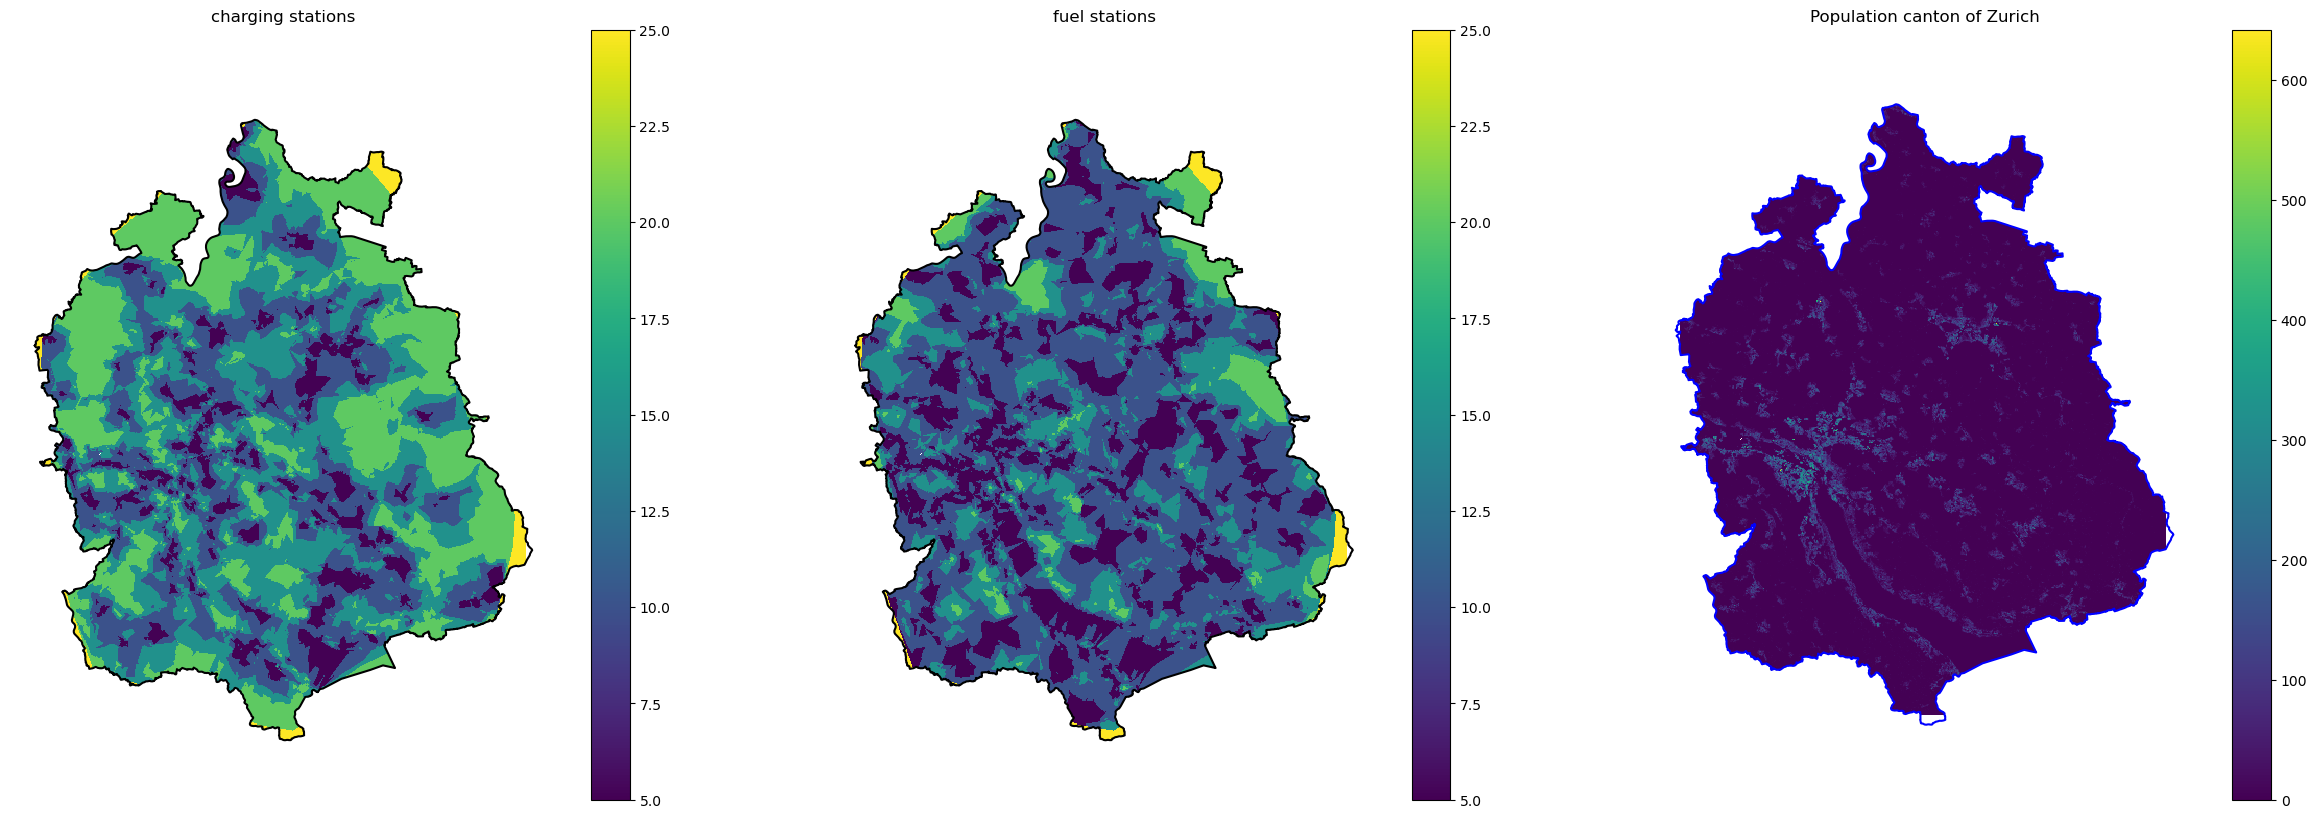

In [16]:
#| label: fig-traveltimes
#| fig-cap: "left and center figures show travel times to charging / fuel stations in minutes and right figure shows population per hectare"

# plot travel times
travel_time_map, axs = plt.subplots(1,3, figsize=(30,10))

Charging_clipped.plot(ax=axs[0])
axs[0].plot(boundary_1, boundary_2, c = "black")
axs[0].set(title="charging stations")
axs[0].set_axis_off()
axs[0].axis("equal")

Fuel_clipped.plot(ax=axs[1])
axs[1].plot(boundary_1, boundary_2, c = "black")
axs[1].set(title="fuel stations")
axs[1].set_axis_off()
axs[1].axis("equal")

ZH_population_clipped.plot(ax=axs[2])
axs[2].set(title="Population canton of Zurich")
axs[2].plot(boundary_1, boundary_2, c = "blue")
axs[2].set_axis_off()
axs[2].axis("equal")

plt.show()

In [12]:
#| label: tbl-accpop
#| tbl-cap: accessibility of charging / fuel stations for population in the canton of Zurich


# calculate percantage of population which is in 5, 10, 15, 20 or 20plus minutes at a charging station
charging_statistics = get_statistics(amenity=Charging, population=ZH_population_clipped)

# calculate percantage of population which is in 5, 10, 15, 20 or 20plus minutes at a fuel station
fuel_statistics = get_statistics(amenity=Fuel, population=ZH_population_clipped)

accessibility = ["< 5 min", "5 to 10 min", "10 to 15 min", "15 to 20 min", "> 20 min"]
results = pd.DataFrame(
    {'accessibility': accessibility,
    'charging station': charging_statistics,
     'fuel station': fuel_statistics
    })
# define appearance of data frame
headers = {
    "selector": "th:not(.index_name)",
    "props": "background-color: #0B4360; color: white; text-align: center"
}

cell_hover = {
    "selector": "td:hover",
    "props": [("background-color", "#75B6D9")]
}

properties = {"border": "1px solid black", "width": "240px", "height": "25px", "text-align": "center"}


results.style.hide(axis="index").set_properties(**properties).set_table_styles([headers, cell_hover]).format({
    "charging station": "{:.1f} %",
    "fuel station": "{:.1f} %"
})

accessibility,charging station,fuel station
< 5 min,15.9 %,36.1 %
5 to 10 min,37.4 %,45.9 %
10 to 15 min,30.4 %,15.5 %
15 to 20 min,16.3 %,2.6 %
> 20 min,0.0 %,0.0 %


# Discussion

##### **Code**
For calculation of travel times, the spatially nearest node from the network to the point data of the charging/fuel station is identified. This nearest node is then taken as the starting point for travel time calculations. However, this leads to certain locations being assigned to the wrong network sections. For example, a charging station located at a highway service area is falsely connected to a node on a country road next to the highway, which means that population living close to this location are incorrectly assigned a short travel time.

Travel times for population at the border to other cantons are not accurate, as the nearest charging or fuel station could be across the border outside the canton of Zurich. Even though travel times for border regions are in some areas to high, this can be neglected, as it only affects a fraction compared to the whole area and both, fuel and charging stations, are subject to this bias. 

Maximum expected travel time for isochrones was set to 40 minutes, as this ensures in a developed area as the canton of Zurich, that any node is covered. Falsely categorized nodes which were not accessible (e.g. dead ends with falsely classified one-way roads) could therefore be ignored for subsequent calculations. However, if the code is to be used for analyses in more rural areas, the maximum expected travel time for isochrones must be increased.

##### **Data**
Due to data protection, grid cells in which three or fewer residents live are not listed at the correct location, but at the location of the respective municipal office (@statistisches_amt_kanton_zurich_dokumentationen_2020). As this concerns only areas with little population, results are only minimally affected and again, both, charging and fuel stations, are subject to this problem. 

##### **FOSS4G compared to proprietary GIS solutions**
Proprietary GIS software such as ArcGIS or Geomedia provide a user-friendly graphical user interface (GUI). This makes it easily accessible for inexperienced users. However, these programs are expensive. Furthermore, some tools may not be available and, in most cases, cannot be added since the developers have absolute authority over the program (@brovelli_free_2012).  FOSS4G on the other hand overcome these issues, as source code is usually published under free and open-source license (@brovelli_free_2012). Furthermore, reproducibility of results and quality assessment of methods are greatly assisted by full access to the underlying algorithms (@brovelli_free_2012). One of the biggest advantages of FOSS4G is the ability to handle repetitive tasks very efficient. However, the use of FOSS4G requires a basic knowledge of programming, which makes it difficult for inexperienced users. This means, that for simple spatial analysis proprietary GIS solutions are a valid choice, however for advanced, repetitive tasks FOSS4G is the advantageous solution.
To solely analyze accessibility of charging and fuel stations in the canton of Zurich, an approach with a proprietary GIS solution would have been more time efficient. However, the chosen method presents a solution which could be applied for any location, given spatial population data is available. Furthermore, the method can not only be applied on charging or fuel stations, but any data provided by open street map. For example, accessibility of hospitals, supermarkets, or sport facilities. In addition, not only the accessibility by car, but also by bicycle or on foot can be calculated depending on the specified network. This emphasizes the advantages of FOSS4G when working on iterative tasks.  

##### **Conclusions**
With less than 10% of all charging processes carried out at public charging stations, this option is only third choice behind private charging (50-80%) and charging at work (15-25%) (@hardman_review_2018). The current expansion can therefore be considered sufficient, taking into account these different user habits. Hence, to further promote e-mobility, the expansion of charging options in private spaces is much more essential. Nonetheless, a well-developed charging infrastructure can encourage more consumers to buy PEVs (@hardman_review_2018), which suggests that the expansion of the charging station infrastructure should be continued in the canton of Zurich. 
